# Baby Cry Detection Model Training
This notebook trains a detection model using YAMNet embeddings to distinguish between cry and non-cry audio.

### 1. Mount Google Drive
Connect to Google Drive to access the dataset and save models.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Setup Paths
Configure paths for dataset and model storage locations. Creates model directory if it doesn't exist.

In [2]:
DATASET_PATH = "/content/drive/MyDrive/FYP Model training/det_dataset"
MODEL_DIR = "/content/drive/MyDrive/FYP Model training/detection_models"

import os
os.makedirs(MODEL_DIR, exist_ok=True)
print("✅ Dataset Path:", DATASET_PATH)
print("✅ Model Save Path:", MODEL_DIR)

✅ Dataset Path: /content/drive/MyDrive/FYP Model training/det_dataset
✅ Model Save Path: /content/drive/MyDrive/FYP Model training/detection_models


### 3. Install Dependencies
Install required Python packages for audio processing, machine learning, and visualization.

In [4]:
# run as a code cell (with "!" prefix)
!pip install --upgrade pip
!pip install tensorflow tensorflow_hub librosa soundfile scikit-learn xgboost joblib matplotlib seaborn tqdm


### 4. Import Libraries and Set Configuration
- Import necessary libraries for data processing and modeling
- Set random seeds for reproducibility
- Configure audio sampling rate (16kHz for YAMNet)
- Define classes: 'not_cry' and 'cry'

In [5]:
import os, random, numpy as np, librosa, joblib
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# audio settings (YAMNet expects 16 kHz)
SR = 16000

# Classes (ensure folder names match)
CLASSES = ['not_cry', 'cry']


### 5. Load YAMNet Model
Load pre-trained YAMNet model from TensorFlow Hub. This model will be used to extract audio embeddings.

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

# load YAMNet model (this will download a model)
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
print("Loading YAMNet from TF Hub (this may take a moment)...")
yamnet = hub.load(yamnet_model_handle)
print("YAMNet loaded.")


Loading YAMNet from TF Hub (this may take a moment)...
YAMNet loaded.


### 6. Prepare Dataset
- Collect file paths and labels from dataset folders
- Split data into train (70%), validation (15%), and test (15%) sets
- Maintain class distribution using stratified split

In [7]:
# collect file paths and labels (0=not_cry, 1=cry)
file_paths = []
file_labels = []

for idx, cls in enumerate(CLASSES):
    folder = os.path.join(DATASET_PATH, cls)
    if not os.path.isdir(folder):
        raise FileNotFoundError(f"Missing folder: {folder}")
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.wav', '.mp3', '.flac', '.ogg'))]
    print(f"{cls}: {len(files)} files")
    file_paths.extend(files)
    file_labels.extend([idx]*len(files))

# stratified split: train 70%, val 15%, test 15%
X_train_files, X_temp_files, y_train_files, y_temp_files = train_test_split(
    file_paths, file_labels, test_size=0.3, stratify=file_labels, random_state=SEED)

X_val_files, X_test_files, y_val_files, y_test_files = train_test_split(
    X_temp_files, y_temp_files, test_size=0.5, stratify=y_temp_files, random_state=SEED)

print("Counts -> train:", len(X_train_files), "val:", len(X_val_files), "test:", len(X_test_files))


not_cry: 324 files
cry: 565 files
Counts -> train: 622 val: 133 test: 134


### 7. Define Feature Extraction
Create function to extract YAMNet embeddings from audio files:
- Loads and resamples audio to 16kHz
- Extracts frame-level embeddings using YAMNet
- Aggregates embeddings using mean and standard deviation
- Returns 2048-dimensional feature vector (1024 mean + 1024 std)

In [8]:
import tensorflow as tf

def extract_yamnet_embedding_for_file(path, yamnet_model=yamnet, sr=SR):
    """
    Returns per-file aggregated embedding vector.
    We'll compute frame-level embeddings from YAMNet and aggregate by mean and std => final vector length = 1024*2 = 2048
    """
    # load at 16 kHz
    wav, _ = librosa.load(path, sr=sr, mono=True)
    # ensure float32
    waveform = wav.astype(np.float32)
    # YAMNet expects shape [num_samples], tf tensor
    waveform_tf = tf.convert_to_tensor(waveform, dtype=tf.float32)
    # run yamnet: returns scores, embeddings, spectrogram
    # embeddings shape: (num_patches, 1024)
    scores, embeddings, spectrogram = yamnet_model(waveform_tf)
    embeddings_np = embeddings.numpy()  # shape (frames, 1024)
    # aggregate: mean and std across frames (axis=0)
    mean_emb = np.mean(embeddings_np, axis=0)
    std_emb  = np.std(embeddings_np, axis=0)
    feat = np.concatenate([mean_emb, std_emb]).astype(np.float32)  # length 2048
    return feat

# quick local test on a small file (uncomment to run)
# test_path = X_train_files[0]
# feat = extract_yamnet_embedding_for_file(test_path)
# print("feature shape:", feat.shape)


### 8. Extract and Cache Features
- Process all audio files to extract YAMNet embeddings
- Cache results to avoid recomputing
- Handle train, validation, and test sets separately

In [9]:
# paths for cached embeddings
cache_train = os.path.join(MODEL_DIR, "emb_train.npy")
cache_val   = os.path.join(MODEL_DIR, "emb_val.npy")
cache_test  = os.path.join(MODEL_DIR, "emb_test.npy")
cache_train_y = os.path.join(MODEL_DIR, "y_train.npy")
cache_val_y   = os.path.join(MODEL_DIR, "y_val.npy")
cache_test_y  = os.path.join(MODEL_DIR, "y_test.npy")

def extract_and_cache(files, labels, out_x_path, out_y_path):
    if os.path.exists(out_x_path) and os.path.exists(out_y_path):
        X = np.load(out_x_path)
        y = np.load(out_y_path)
        print("Loaded cache:", out_x_path, X.shape)
        return X, y
    feats = []
    labs = []
    for p, lbl in tqdm(zip(files, labels), total=len(files), desc="Extracting embeddings"):
        try:
            f = extract_yamnet_embedding_for_file(p)
            feats.append(f)
            labs.append(lbl)
        except Exception as e:
            print("Failed:", p, e)
    X = np.vstack(feats)
    y = np.array(labs, dtype=np.int32)
    np.save(out_x_path, X)
    np.save(out_y_path, y)
    print("Saved:", out_x_path, X.shape)
    return X, y

X_train_emb, y_train = extract_and_cache(X_train_files, y_train_files, cache_train, cache_train_y)
X_val_emb, y_val = extract_and_cache(X_val_files, y_val_files, cache_val, cache_val_y)
X_test_emb, y_test = extract_and_cache(X_test_files, y_test_files, cache_test, cache_test_y)


Extracting embeddings: 100%|██████████| 622/622 [03:42<00:00,  2.80it/s]


Saved: /content/drive/MyDrive/FYP Model training/detection_models/emb_train.npy (622, 2048)


Extracting embeddings: 100%|██████████| 133/133 [00:42<00:00,  3.13it/s]


Saved: /content/drive/MyDrive/FYP Model training/detection_models/emb_val.npy (133, 2048)


Extracting embeddings: 100%|██████████| 134/134 [00:43<00:00,  3.10it/s]

Saved: /content/drive/MyDrive/FYP Model training/detection_models/emb_test.npy (134, 2048)


### 9. Preprocess Features
- Apply StandardScaler to normalize features
- Reduce dimensionality using PCA (2048 → 256 dimensions)
- Save preprocessing objects for inference

In [10]:
# scaler + PCA pipeline
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_yamnet.pkl")
PCA_PATH = os.path.join(MODEL_DIR, "pca_yamnet.pkl")

# choose n_components to reduce from 2048 -> e.g., 256 (adjust as needed)
N_PCA = 256

if os.path.exists(SCALER_PATH) and os.path.exists(PCA_PATH):
    scaler = joblib.load(SCALER_PATH)
    pca = joblib.load(PCA_PATH)
    X_train_p = pca.transform(scaler.transform(X_train_emb))
    X_val_p = pca.transform(scaler.transform(X_val_emb))
    X_test_p = pca.transform(scaler.transform(X_test_emb))
    print("Loaded scaler + PCA. Shapes:", X_train_p.shape, X_val_p.shape, X_test_p.shape)
else:
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(X_train_emb)
    pca = PCA(n_components=N_PCA, random_state=SEED)
    Xtr_p = pca.fit_transform(Xtr_s)
    # transform val/test
    X_val_p = pca.transform(scaler.transform(X_val_emb))
    X_test_p = pca.transform(scaler.transform(X_test_emb))
    X_train_p = Xtr_p
    # save scaler + pca
    joblib.dump(scaler, SCALER_PATH)
    joblib.dump(pca, PCA_PATH)
    print("Saved scaler & PCA. Train shape:", X_train_p.shape)


Saved scaler & PCA. Train shape: (622, 256)


### 10. Train Models
Train and evaluate three models:
1. Logistic Regression (with balanced class weights)
2. Random Forest (with balanced class weights)
3. XGBoost
Compare models using PR-AUC (Precision-Recall Area Under Curve)

In [11]:
# We'll train three models and compare validation performance (use class_weight for LR and RF)
results = {}

# 1) Logistic Regression (with class weight balanced)
print("Training LogisticRegression...")
lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=SEED, solver='saga')
lr.fit(X_train_p, y_train)
val_probs_lr = lr.predict_proba(X_val_p)[:,1]
val_preds_lr = (val_probs_lr >= 0.5).astype(int)
print("LR val acc:", accuracy_score(y_val, val_preds_lr))
print(classification_report(y_val, val_preds_lr, target_names=CLASSES))
results['lr'] = (lr, val_probs_lr)

# 2) Random Forest
print("\nTraining RandomForest...")
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=SEED, n_jobs=-1)
rf.fit(X_train_p, y_train)
val_probs_rf = rf.predict_proba(X_val_p)[:,1]
val_preds_rf = (val_probs_rf >= 0.5).astype(int)
print("RF val acc:", accuracy_score(y_val, val_preds_rf))
print(classification_report(y_val, val_preds_rf, target_names=CLASSES))
results['rf'] = (rf, val_probs_rf)

# 3) XGBoost
print("\nTraining XGBoost...")
# compute scale_pos_weight = (neg / pos) for imbalance
neg = np.sum(y_train==0)
pos = np.sum(y_train==1)
scale_pos = neg / (pos + 1e-9)
xgb_clf = xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                            random_state=SEED, use_label_encoder=False, eval_metric='logloss',
                            n_jobs=-1)
xgb_clf.fit(X_train_p, y_train)
val_probs_xgb = xgb_clf.predict_proba(X_val_p)[:,1]
val_preds_xgb = (val_probs_xgb >= 0.5).astype(int)
print("XGB val acc:", accuracy_score(y_val, val_preds_xgb))
print(classification_report(y_val, val_preds_xgb, target_names=CLASSES))
results['xgb'] = (xgb_clf, val_probs_xgb)

# Compare AUC-PR on validation
from sklearn.metrics import precision_recall_curve, auc
for name, (m, probs) in results.items():
    prec, rec, thr = precision_recall_curve(y_val, probs)
    pr_auc = auc(rec, prec)
    print(f"{name} PR-AUC: {pr_auc:.4f}")


Training LogisticRegression...
LR val acc: 0.9849624060150376
              precision    recall  f1-score   support

     not_cry       0.96      1.00      0.98        48
         cry       1.00      0.98      0.99        85

    accuracy                           0.98       133
   macro avg       0.98      0.99      0.98       133
weighted avg       0.99      0.98      0.99       133


Training RandomForest...
RF val acc: 0.924812030075188
              precision    recall  f1-score   support

     not_cry       1.00      0.79      0.88        48
         cry       0.89      1.00      0.94        85

    accuracy                           0.92       133
   macro avg       0.95      0.90      0.91       133
weighted avg       0.93      0.92      0.92       133


Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:18:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB val acc: 0.9624060150375939
              precision    recall  f1-score   support

     not_cry       0.94      0.96      0.95        48
         cry       0.98      0.96      0.97        85

    accuracy                           0.96       133
   macro avg       0.96      0.96      0.96       133
weighted avg       0.96      0.96      0.96       133

lr PR-AUC: 1.0000
rf PR-AUC: 0.9987
xgb PR-AUC: 0.9968


### 11. Evaluate Best Model
- Select best model based on validation PR-AUC
- Find optimal classification threshold using F1 score
- Evaluate on test set:
  - Classification report
  - Confusion matrix
  - Precision-Recall curve

Best model on val PR-AUC: lr 0.9999999999999998
Threshold chosen (best F1 on val): 0.21193042 F1: 0.9999999995
Test Accuracy: 0.9776119402985075
              precision    recall  f1-score   support

     not_cry       0.96      0.98      0.97        49
         cry       0.99      0.98      0.98        85

    accuracy                           0.98       134
   macro avg       0.97      0.98      0.98       134
weighted avg       0.98      0.98      0.98       134



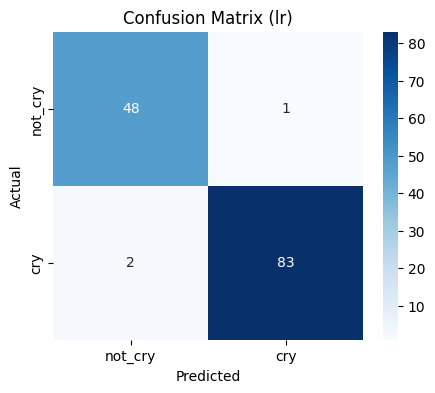

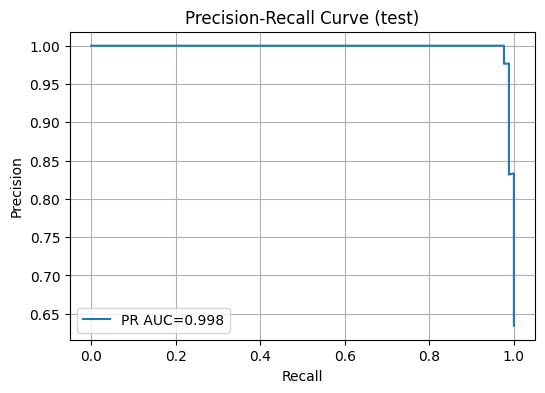

In [12]:
# Choose the model with highest PR-AUC on validation
best_name = None
best_auc = -1
for name, (m, probs) in results.items():
    prec, rec, thr = precision_recall_curve(y_val, probs)
    pr_auc = auc(rec, prec)
    if pr_auc > best_auc:
        best_auc = pr_auc
        best_name = name

print("Best model on val PR-AUC:", best_name, best_auc)

best_model, best_val_probs = results[best_name]

# Tune threshold on validation for best F1 or desired recall
prec, rec, thr = precision_recall_curve(y_val, best_val_probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1_scores)
best_threshold = thr[best_idx] if best_idx < len(thr) else 0.5
print("Threshold chosen (best F1 on val):", best_threshold, "F1:", f1_scores[best_idx])

# Evaluate on test with that threshold
# prepare test features: X_test_p exists
test_probs = best_model.predict_proba(X_test_p)[:,1]
test_preds = (test_probs >= best_threshold).astype(int)

print("Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds, target_names=CLASSES))

# Confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix ({best_name})")
plt.show()

# also show PR curve on test
prec_t, rec_t, thr_t = precision_recall_curve(y_test, test_probs)
pr_auc_test = auc(rec_t, prec_t)
plt.figure(figsize=(6,4))
plt.plot(rec_t, prec_t, label=f'PR AUC={pr_auc_test:.3f}')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve (test)")
plt.legend(); plt.grid(); plt.show()


### 12. Save Model Artifacts
Save the best model and preprocessing objects (scaler, PCA) for deployment:
- Model saved as joblib file
- Scaler and PCA transformers already saved
These files will be used for inference in the deployment application.

In [13]:
# Save chosen model and preprocessing objects
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, f"yamnet_{best_name}_model.joblib")
joblib.dump(best_model, MODEL_SAVE_PATH)
print("Saved model to:", MODEL_SAVE_PATH)

# scaler & pca paths already saved earlier; ensure they exist
print("Scaler path:", SCALER_PATH)
print("PCA path:", PCA_PATH)
print("You can load them to run inference: joblib.load(...)")


Saved model to: /content/drive/MyDrive/FYP Model training/detection_models/yamnet_lr_model.joblib
Scaler path: /content/drive/MyDrive/FYP Model training/detection_models/scaler_yamnet.pkl
PCA path: /content/drive/MyDrive/FYP Model training/detection_models/pca_yamnet.pkl
You can load them to run inference: joblib.load(...)
